In [53]:
import pandas as pd
import numpy as np
from datetime import datetime
from geopy.distance import geodesic  # For calculating distance
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("amazon_delivery.csv")

In [3]:

df.head()


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


In [9]:
df.describe()

,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Delivery_Time
count,43739.000000,43685.000000,43739.000000,43739.000000,43739.000000,43739.000000,43739.000000
mean,29.567137,4.633780,17.210960,70.661177,17.459031,70.821842,124.905645
std,5.815155,0.334716,7.764225,21.475005,7.342950,21.153148,51.915451
min,15.000000,1.000000,-30.902872,-88.366217,0.010000,0.010000,10.000000
25%,25.000000,4.500000,12.933298,73.170283,12.985996,73.280000,90.000000
50%,30.000000,4.700000,18.551440,75.898497,18.633626,76.002574,125.000000
75%,35.000000,4.900000,22.732225,78.045359,22.785049,78.104095,160.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,270.000000


In [10]:
df.isnull().sum()

Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64

In [5]:
# Fill missing Agent_Rating with median
df['Agent_Rating'].fillna(df['Agent_Rating'].median(), inplace=True)

# Fill missing Weather with mode
df['Weather'].fillna(df['Weather'].mode()[0], inplace=True)

# Check again for missing values
print("✅ Missing values after cleaning:")
print(df.isnull().sum())


✅ Missing values after cleaning:
Order_ID           0
Agent_Age          0
Agent_Rating       0
Store_Latitude     0
Store_Longitude    0
Drop_Latitude      0
Drop_Longitude     0
Order_Date         0
Order_Time         0
Pickup_Time        0
Weather            0
Traffic            0
Vehicle            0
Area               0
Delivery_Time      0
Category           0
dtype: int64


In [6]:
# Clean and convert Order_Date + Order_Time to datetime
df['Order_DateTime'] = pd.to_datetime(
    df['Order_Date'].str.strip() + ' ' + df['Order_Time'].str.strip(),
    errors='coerce'
)

# Clean and convert Pickup_Time to datetime
df['Pickup_DateTime'] = pd.to_datetime(
    df['Order_Date'].str.strip() + ' ' + df['Pickup_Time'].str.strip(),
    errors='coerce'
)

# Check for failed datetime parsing (NaT values)
print("NaT in Order_DateTime:", df['Order_DateTime'].isnull().sum())
print("NaT in Pickup_DateTime:", df['Pickup_DateTime'].isnull().sum())


NaT in Order_DateTime: 91
NaT in Pickup_DateTime: 0


In [54]:
df = df.dropna(subset=['Order_DateTime', 'Pickup_DateTime'])

In [55]:
df['Order_Hour'] = df['Order_DateTime'].dt.hour
df['Order_Weekday'] = df['Order_DateTime'].dt.dayofweek
df['Order_to_Pickup_Min'] = (df['Pickup_DateTime'] - df['Order_DateTime']).dt.total_seconds() / 60.0

In [56]:
# Define a function to calculate geodesic distance
def calc_distance(row):
    store_loc = (row['Store_Latitude'], row['Store_Longitude'])
    drop_loc = (row['Drop_Latitude'], row['Drop_Longitude'])
    return geodesic(store_loc, drop_loc).km

# Apply function row-wise
df['Distance_km'] = df.apply(calc_distance, axis=1)

# Preview results
print("✅ Distance calculated:")
print(df[['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Distance_km']].head())

# Basic check
print("Min distance:", df['Distance_km'].min())
print("Max distance:", df['Distance_km'].max())


✅ Distance calculated:
   Store_Latitude  Store_Longitude  Drop_Latitude  Drop_Longitude  Distance_km
0       22.745049        75.892471      22.765049       75.912471     3.020737
1       12.913041        77.683237      13.043041       77.813237    20.143737
2       12.914264        77.678400      12.924264       77.688400     1.549693
3       11.003669        76.976494      11.053669       77.026494     7.774497
4       12.972793        80.249982      13.012793       80.289982     6.197898
Min distance: 1.4638371061422368
Max distance: 20.94290627698551


In [57]:
df = df[df['Distance_km'] < 1000]  # Example threshold


In [58]:
def categorize_distance(d):
    if d < 5:
        return 'Short'
    elif d < 15:
        return 'Medium'
    else:
        return 'Long'

df['Distance_Category'] = df['Distance_km'].apply(categorize_distance)


In [18]:
print(df['Distance_Category'].value_counts())


Distance_Category
Medium    23513
Short     11722
Long       8316
Name: count, dtype: int64


In [8]:
# Save original columns for plotting later
df['Weather_Original'] = df['Weather']
df['Traffic_Original'] = df['Traffic']
df['Vehicle_Original'] = df['Vehicle']
df['Area_Original'] = df['Area']
df['Category_Original'] = df['Category']


In [19]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns to encode
cat_cols = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']

# Initialize encoders
encoders = {}

# Encode each column
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le 

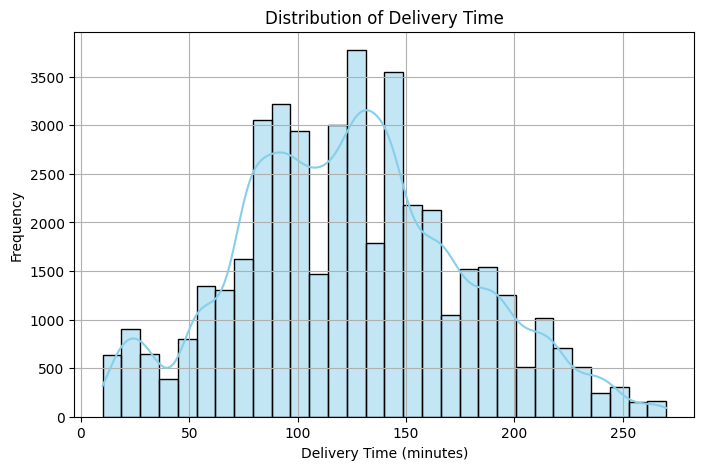

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['Delivery_Time'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Delivery Time')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


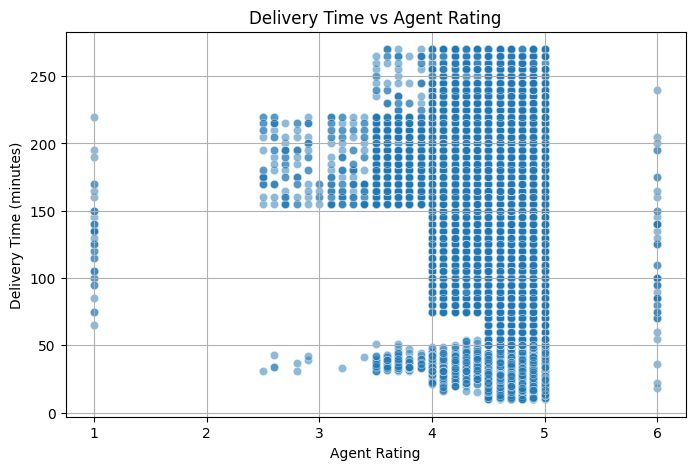

In [11]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Agent_Rating', y='Delivery_Time', alpha=0.5)
plt.title('Delivery Time vs Agent Rating')
plt.xlabel('Agent Rating')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True)
plt.show()


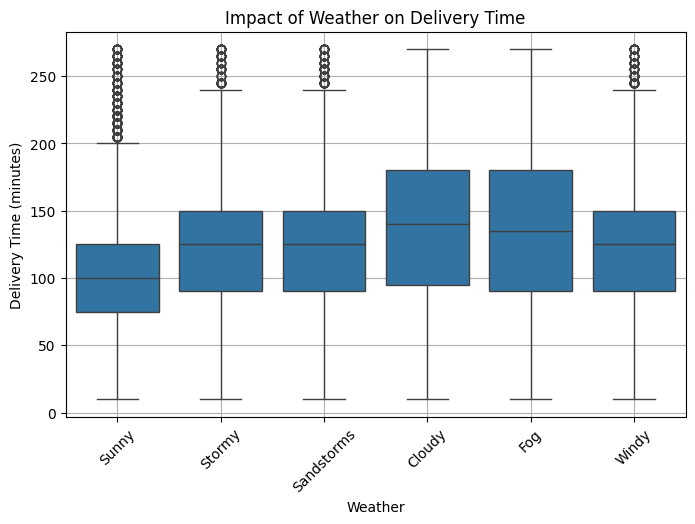

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Weather_Original', y='Delivery_Time')
plt.title('Impact of Weather on Delivery Time')
plt.xlabel('Weather')
plt.ylabel('Delivery Time (minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


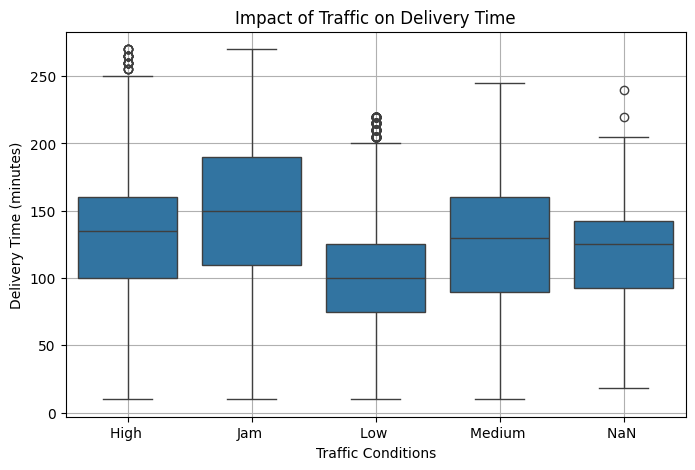

In [13]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Traffic_Original', y='Delivery_Time')
plt.title('Impact of Traffic on Delivery Time')
plt.xlabel('Traffic Conditions')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True)
plt.show()


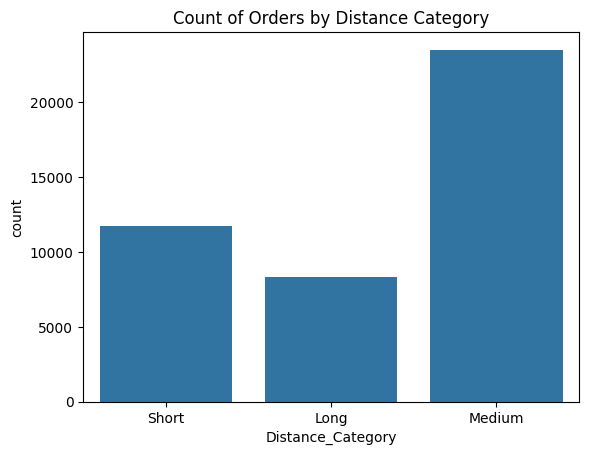

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Distance_Category')
plt.title('Count of Orders by Distance Category')
plt.show()


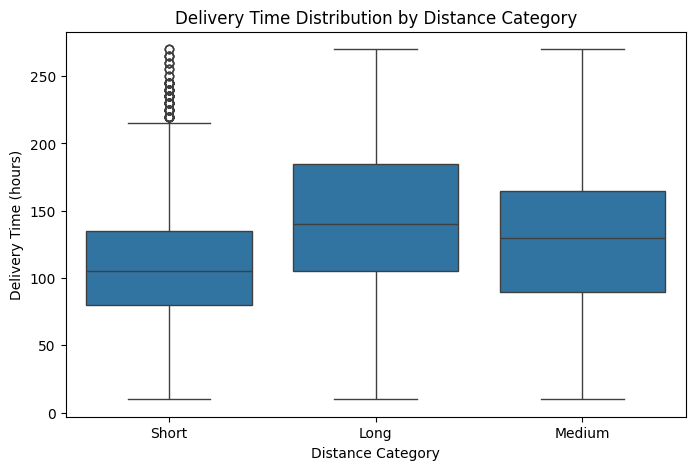

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Distance_Category', y='Delivery_Time')

plt.title('Delivery Time Distribution by Distance Category')
plt.xlabel('Distance Category')
plt.ylabel('Delivery Time (hours)')  # Change to 'minutes' if your data is in minutes
plt.show()


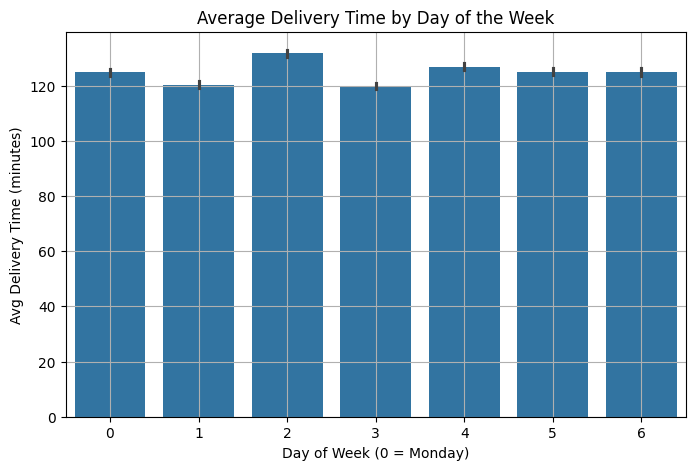

In [28]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Order_Weekday', y='Delivery_Time', data=df)
plt.title('Average Delivery Time by Day of the Week')
plt.xlabel('Day of Week (0 = Monday)')
plt.ylabel('Avg Delivery Time (minutes)')
plt.grid(True)
plt.show()


In [61]:
from sklearn.preprocessing import LabelEncoder

# Include Distance_Category in categorical columns
cat_cols = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category', 'Distance_Category']

# Initialize encoders dictionary if not already done
encoders = {}

# Encode each categorical column to numeric
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le


In [62]:
feature_cols = ['Distance_km', 'Agent_Rating', 'Order_Hour', 'Order_Weekday', 'Order_to_Pickup_Min',
                'Weather', 'Traffic', 'Vehicle', 'Area', 'Category', 'Distance_Category']
X = df[feature_cols]
y = df['Delivery_Time']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
import numpy as np
from sklearn.impute import SimpleImputer

# Step 1: Check shape of data
print("Before cleaning → X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)

# Step 2: Replace inf with NaN (just to be safe)
X_train = np.where(np.isinf(X_train), np.nan, X_train)

# Step 3: Impute NaN with mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# Step 4: Force float32 conversion to prevent dtype issues
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

# Step 5: Confirm cleaning
print("✅ NaNs in X_train:", np.isnan(X_train).sum())
print("✅ Infs in X_train:", np.isinf(X_train).sum())
print("✅ dtype of X_train:", X_train.dtype)
print("✅ Max value in X_train:", np.max(X_train))
print("✅ Min value in X_train:", np.min(X_train))


Before cleaning → X_train shape: (34793, 11) | y_train shape: (34793,)
✅ NaNs in X_train: 0
✅ Infs in X_train: 0
✅ dtype of X_train: float32
✅ Max value in X_train: 2.3388603
✅ Min value in X_train: -7.326247


In [51]:
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"📊 {model_name} Performance:")
    print(f"➡ RMSE: {rmse:.2f}")
    print(f"➡ MAE: {mae:.2f}")
    print(f"➡ R²: {r2:.2f}")
    
    return model, rmse, mae, r2


In [65]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [66]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

def evaluate_and_log(model, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    with mlflow.start_run(run_name=name):
        mlflow.log_param("model", name)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)
        mlflow.sklearn.log_model(model, artifact_path=f"{name}_model")

    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
    return model, rmse, mae, r2


In [67]:
results = {}
for name, model in models.items():
    results[name] = evaluate_and_log(model, name)

2025/06/27 23:03:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/27 23:03:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LinearRegression - RMSE: 45.05, MAE: 34.97, R2: 0.25


2025/06/27 23:03:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/27 23:03:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest - RMSE: 28.49, MAE: 21.86, R2: 0.70


2025/06/27 23:03:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/27 23:03:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GradientBoosting - RMSE: 28.48, MAE: 22.23, R2: 0.70


In [69]:
import pickle

# Save Random Forest model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(models["RandomForest"], f)

# Save StandardScaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


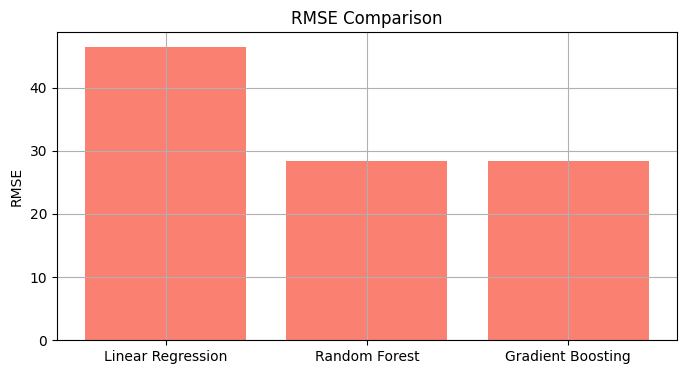

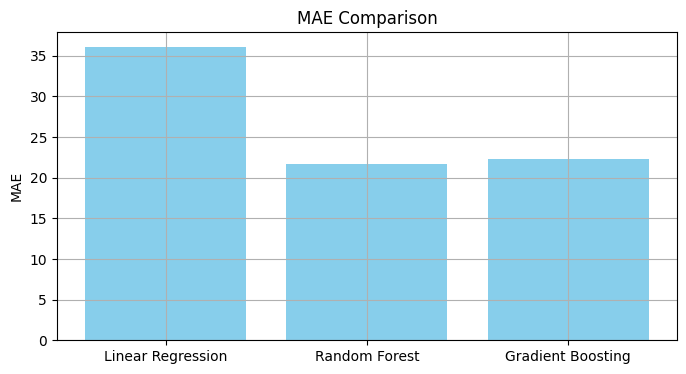

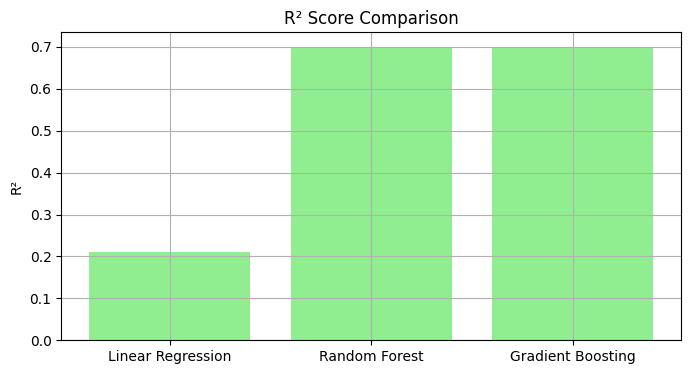

In [70]:
import matplotlib.pyplot as plt

# Model scores from earlier
model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
rmses = [46.43, 28.38, 28.45]
maes = [36.09, 21.72, 22.27]
r2s = [0.21, 0.70, 0.70]

# RMSE plot
plt.figure(figsize=(8, 4))
plt.bar(model_names, rmses, color='salmon')
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# MAE plot
plt.figure(figsize=(8, 4))
plt.bar(model_names, maes, color='skyblue')
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

# R² Score plot
plt.figure(figsize=(8, 4))
plt.bar(model_names, r2s, color='lightgreen')
plt.title('R² Score Comparison')
plt.ylabel('R²')
plt.grid(True)
plt.show()
